In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imb_pipe
import matplotlib
from sklearn.pipeline import Pipeline 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the data
df = pd.read_excel('data/Bank_Personal_Loan_Modelling.xlsx',sheet_name=1)

# Splitting the Data

In [3]:
# Split the predictor and target variables
y = df['Personal Loan']
X = df.drop('Personal Loan',axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

# Unoversampled RFC Pipeline

In [4]:
# Build a pipeline with StandardScaler and RandomForestClassifier
rfc_pipeline = Pipeline([('ss', StandardScaler()), 
                              ('RF', RandomForestClassifier(random_state=123))])

In [5]:
# Define the grid
rfc_grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [2, 5, 10], 
         'RF__min_samples_leaf': [1, 3, 5]}]
# Define a grid search
rfc_gridsearch = GridSearchCV(estimator=rfc_pipeline, 
                          param_grid=rfc_grid, 
                          scoring='accuracy', 
                          cv=5)

In [6]:
# Fit the training data
rfc_gridsearch.fit(X_train, y_train)
rfc_best_model = rfc_gridsearch.best_estimator_
rfc_best_model.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('RF',
                 RandomForestClassifier(max_depth=6, min_samples_split=10,
                                        random_state=123))])

Accuracy: 0.9808
Recall: 0.8283582089552238
Precision: 0.9910714285714286
F1 : 0.9024390243902439


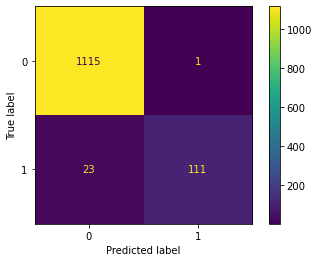

In [7]:
rfc_y_pred = rfc_best_model.predict(X_test)
#accuracy_score, recall_score, precision_score, f1_score
print("Accuracy: {}".format(accuracy_score(y_test,rfc_y_pred)) )
print("Recall: {}".format(recall_score(y_test,rfc_y_pred)) )
print("Precision: {}".format(precision_score(y_test,rfc_y_pred)) )
print("F1 : {}".format(f1_score(y_test,rfc_y_pred)) )
plot_confusion_matrix(rfc_best_model,X_test,y_test)

# Second Pipeline with Oversampling
### variables with name _ros are the over sampled 

In [8]:
# now we will try and oversample the target variable
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy=1)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [9]:
print(y_train_ros.size)
print(y_train.value_counts())
print(y_train_ros.value_counts())

6808
0    3404
1     346
Name: Personal Loan, dtype: int64
1    3404
0    3404
Name: Personal Loan, dtype: int64


In [10]:
# Build a pipeline with StandardScaler and RandomForestClassifier
ros_pipeline = Pipeline([('ss', StandardScaler()), 
                              ('RF', RandomForestClassifier(random_state=123))])
# Define the grid
ros_grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [2, 5, 10], 
         'RF__min_samples_leaf': [1, 3, 5]}]
# Define a grid search
ros_gridsearch = GridSearchCV(estimator=ros_pipeline, 
                          param_grid=ros_grid, 
                          scoring='accuracy', 
                          cv=5)

In [11]:

# Fit the training data
ros_gridsearch.fit(X_train_ros, y_train_ros)
ros_best_model = ros_gridsearch.best_estimator_
ros_best_model.fit(X_train_ros,y_train_ros)

Pipeline(steps=[('ss', StandardScaler()),
                ('RF', RandomForestClassifier(max_depth=6, random_state=123))])

Accuracy: 0.9776
Recall: 0.9701492537313433
Precision: 0.8441558441558441
F1 : 0.9027777777777779


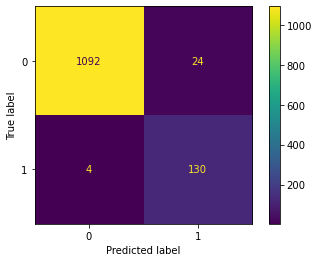

In [12]:

ros_y_pred = ros_best_model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test,ros_y_pred)))
print("Recall: {}".format(recall_score(y_test,ros_y_pred)))
print("Precision: {}".format(precision_score(y_test,ros_y_pred)))
print("F1 : {}".format(f1_score(y_test,ros_y_pred)))
plot_confusion_matrix(ros_best_model,X_test,y_test)

# Confusion Matrix Comparison

Un-oversampled Random Forest


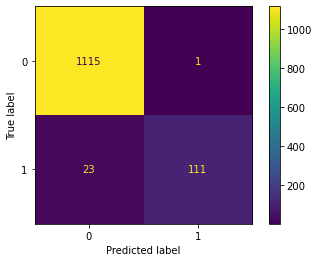

In [13]:
print("Un-oversampled Random Forest")
plot_confusion_matrix(rfc_best_model,X_test,y_test)

oversampled Random Forest


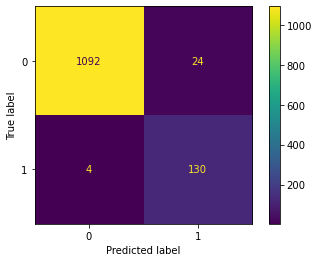

In [14]:
print("oversampled Random Forest")
plot_confusion_matrix(ros_best_model,X_test,y_test)

### As you can see, oversampling increases the amount of False Positives, which in the case of bank loans is not good; you don't want to be giving out loans to those who don't deserve it

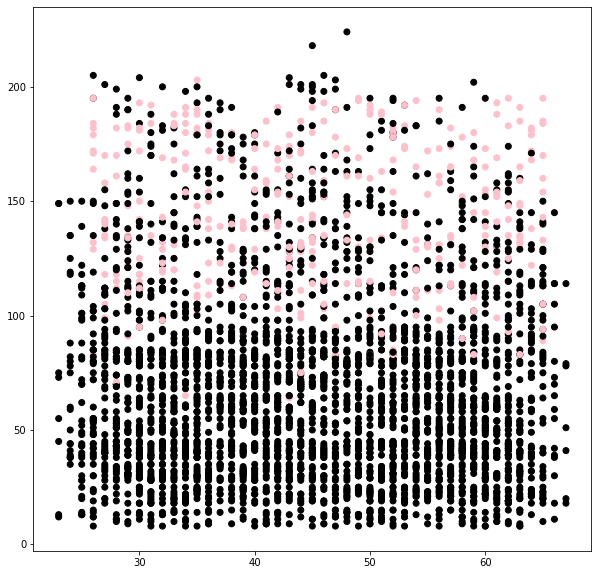

In [15]:
cmap = matplotlib.colors.ListedColormap(['black', 'pink'])
plt.figure(figsize=(10,10))
plt.scatter(X_train.Age,X_train.Income,c=y_train,cmap=cmap)

plt.show()

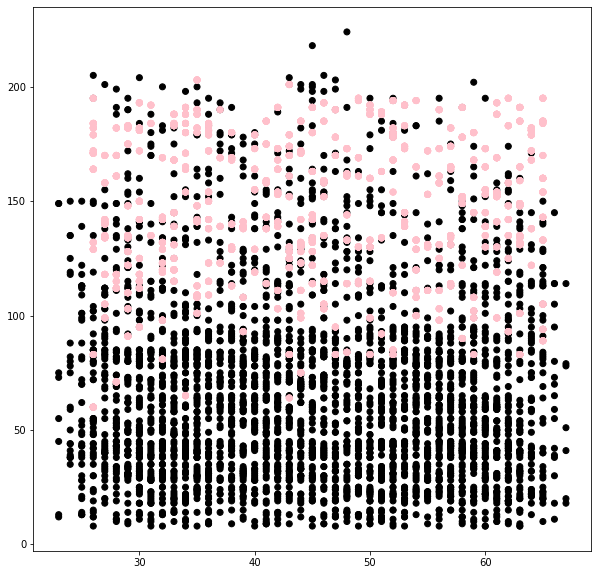

In [16]:


plt.figure(figsize=(10,10))
plt.scatter(X_train_ros.Age,X_train_ros.Income,c=y_train_ros,cmap=cmap)

plt.show()

### the imblearns seems to be creating a lot of dublicate y = 1 values but also adding some y=1 values in the area where a lot of purple dots are.  This may be why the amount of false positives have increased in the oversampled pipeline

# SMOTE IMBlearn Pipeline

In [17]:
import imblearn

In [30]:
# define pipeline
model = RandomForestClassifier(random_state=123)
smote_pipeline = imb_pipe(steps=[('over', SMOTE(random_state=123)), 
                                 ('under', RandomUnderSampler(random_state=123)), 
                                 ('RF', model)])
smote_grid = [{'RF__n_estimators':[100,250,400,600,800,1000],
         'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [2, 5, 10], 
         'RF__min_samples_leaf': [1, 3, 5],
         'over__sampling_strategy': [0.1, 0.2, 0.4,0.6,0.75,1],
         'under__sampling_strategy': [0.5, 0.6, 0.7,0.8,0.9,1]     }]
smote_gridsearch = GridSearchCV(estimator=smote_pipeline, 
                          param_grid=smote_grid, 
                          scoring='roc_auc', 
                          cv=8,
                          n_jobs=-1
                          )


In [31]:
smote_gridsearch.fit(X_train,y_train)

GridSearchCV(cv=8,
             estimator=Pipeline(steps=[('over', SMOTE(random_state=123)),
                                       ('under',
                                        RandomUnderSampler(random_state=123)),
                                       ('RF',
                                        RandomForestClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid=[{'RF__max_depth': [4, 5, 6],
                          'RF__min_samples_leaf': [1, 3, 5],
                          'RF__min_samples_split': [2, 5, 10],
                          'RF__n_estimators': [100, 250, 400, 600, 800, 1000],
                          'over__sampling_strategy': [0.1, 0.2, 0.4, 0.6, 0.75,
                                                      1],
                          'under__sampling_strategy': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                       1]}],
             scoring='roc_auc')

In [20]:
smote_best_model = smote_gridsearch.best_estimator_
smote_best_model.fit(X_train,y_train)

Pipeline(steps=[('over', SMOTE(random_state=123, sampling_strategy=0.4)),
                ('under',
                 RandomUnderSampler(random_state=123, sampling_strategy=0.5)),
                ('RF',
                 RandomForestClassifier(max_depth=6, min_samples_split=5,
                                        n_estimators=400, random_state=123))])

Accuracy: 0.9824
Recall: 0.9328358208955224
Precision: 0.9057971014492754
F1 : 0.9191176470588236


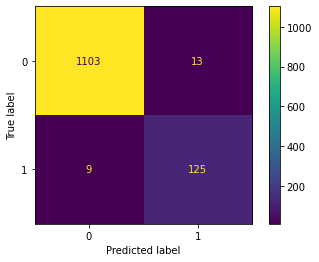

In [29]:
smote_y_pred = smote_best_model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test,smote_y_pred)))
print("Recall: {}".format(recall_score(y_test,smote_y_pred)))
print("Precision: {}".format(precision_score(y_test,smote_y_pred)))
print("F1 : {}".format(f1_score(y_test,smote_y_pred)))
plot_confusion_matrix(smote_best_model,X_test,y_test)

In [64]:
good_pipe = imb_pipe(steps=[('over', SMOTE( sampling_strategy=0.4)),
                ('under',
                 RandomUnderSampler( sampling_strategy=0.5)),
                ('RF',
                 RandomForestClassifier(max_depth=6, min_samples_split=5,
                                        n_estimators=400))])

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.4)),
                ('under', RandomUnderSampler(sampling_strategy=0.5)),
                ('RF',
                 RandomForestClassifier(max_depth=6, min_samples_split=5,
                                        n_estimators=400))])

Accuracy: 0.9848
Recall: 0.9477611940298507
Precision: 0.9136690647482014
F1 : 0.9304029304029303


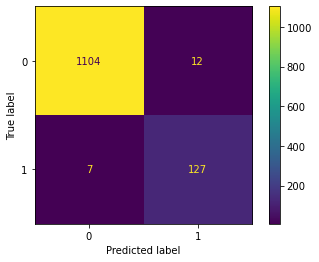

In [87]:
good_pipe.fit(X_train,y_train)
good_y_pred = good_pipe.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test,good_y_pred)))
print("Recall: {}".format(recall_score(y_test,good_y_pred)))
print("Precision: {}".format(precision_score(y_test,good_y_pred)))
print("F1 : {}".format(f1_score(y_test,good_y_pred)))
plot_confusion_matrix(good_pipe,X_test,y_test)

In [77]:
roc_pipe = imb_pipe(steps=[('over', SMOTE( sampling_strategy=0.4)),
                ('under',
                 RandomUnderSampler( sampling_strategy=0.5)),
                ('RF',
                 RandomForestClassifier(max_depth=6, min_samples_split=5,
                                        n_estimators=400))])

Accuracy: 0.9824
Recall: 0.9253731343283582
Precision: 0.9117647058823529
F1 : 0.9185185185185185


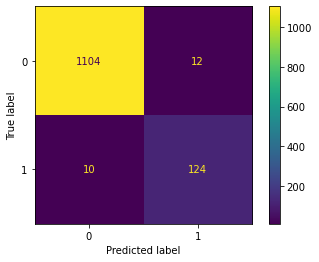

In [81]:
roc_pipe.fit(X_train,y_train)

roc_y_pred = roc_pipe.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test,roc_y_pred)))
print("Recall: {}".format(recall_score(y_test,roc_y_pred)))
print("Precision: {}".format(precision_score(y_test,roc_y_pred)))
print("F1 : {}".format(f1_score(y_test,roc_y_pred)))
plot_confusion_matrix(roc_pipe,X_test,y_test)